In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn import metrics

from scipy import stats
from collections import Counter

In [2]:
df = pd.read_csv('vehicles.csv')
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


## Data Cleaning & EDA

In [3]:
# get information about all the columns in the dataset
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [4]:
# get information about the shape of the data matrix
df.shape

(426880, 26)

In [5]:
# get information number of data observations in the dataset columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [6]:
# check the rows in the dataset that are duplicated
df.duplicated().value_counts()

False    426880
dtype: int64

In [7]:
df.title_status.unique()

array([nan, 'clean', 'rebuilt', 'lien', 'salvage', 'missing',
       'parts only'], dtype=object)

In [8]:
# Check the count of the values in the 'cylinders' column
Counter(df['cylinders'])

Counter({nan: 177678,
         '8 cylinders': 72062,
         '6 cylinders': 94169,
         '4 cylinders': 77642,
         '5 cylinders': 1712,
         'other': 1298,
         '3 cylinders': 655,
         '10 cylinders': 1455,
         '12 cylinders': 209})

In [9]:
# Remove the cylinders in the row values and retain the corresponding digits
df['cylinders'].replace(to_replace=['3 cylinders','4 cylinders','5 cylinders','6 cylinders','8 cylinders',
                                    '10 cylinders','12 cylinders'],
                        value=[3,4,5,6,8,10,12],inplace=True) 

In [10]:
Counter(df['cylinders'])

Counter({nan: 177678,
         8: 72062,
         6: 94169,
         4: 77642,
         5: 1712,
         'other': 1298,
         3: 655,
         10: 1455,
         12: 209})

In [11]:
# drop columns that would not be useful for now
df = df.drop(columns = ['id','url','region_url', 'image_url','county', 'VIN', 
                        'description', 'posting_date', 'size', 'lat', 'long', 'state', 
                       'region', 'model'])

In [12]:
# check the rows in the dataset that are duplicated
df.duplicated().value_counts()

False    244870
True     182010
dtype: int64

In [13]:
# drop duplicate rows
df.drop_duplicates(inplace=True)

In [14]:
# check the current shape of the dataset matrix without duplicates
df.shape

(244870, 12)

In [15]:
# check for missing values
df.isna().sum()

price               0
year              695
manufacturer    10667
condition       97002
cylinders       87773
fuel             1636
odometer         2416
title_status     4134
transmission     1287
drive           69580
type            61526
paint_color     73199
dtype: int64

In [16]:
# drop missing values in year, model, fuel, odometer, transmission 
df.dropna(subset=['year','fuel','odometer','transmission'],axis=0,inplace=True)
df.shape

(239635, 12)

In [17]:
#drop all concurrent missing values in manufacturer, condition, cylinders, title status, drive, type, paint color 
df.dropna(subset=['manufacturer', 'condition', 'cylinders', 'title_status', 
                    'drive', 'type', 'paint_color'], axis=0, how='all', inplace=True)
df.shape

(239635, 12)

It looks like there are no rows with concurrent missing values

In [18]:
df.isna().sum()

price               0
year                0
manufacturer     9829
condition       92808
cylinders       84861
fuel                0
odometer            0
title_status     3492
transmission        0
drive           67962
type            60736
paint_color     71447
dtype: int64

In [19]:
df.dropna(subset=['manufacturer', 'condition', 'cylinders', 'title_status', 
                    'drive', 'type', 'paint_color'], axis=0, inplace=True)
df.shape

(80401, 12)

In [20]:
df.isna().sum()

price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
dtype: int64

In [21]:
df['price'].min()

0

In [22]:
df['price'].max()

3736928711

Based on the minimum and maximum values of the price which are extreme values, it appears there are outliers

In [23]:
# view the high priced car outliers
outlier = df.loc[((df.price > 500_000) & (df.price < 100_000_000_000))]
outlier.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
29386,1111111111,1999.0,ford,good,8,diesel,149000.0,clean,automatic,rwd,pickup,white
68935,2000000,2002.0,saturn,good,4,gas,164290.0,clean,automatic,fwd,sedan,green
136516,17000000,2007.0,ram,good,8,diesel,170000.0,rebuilt,automatic,4wd,pickup,black
137807,123456789,1999.0,buick,like new,6,gas,96000.0,clean,automatic,fwd,sedan,white
155421,1234567,2006.0,jeep,like new,6,gas,123456.0,clean,automatic,4wd,SUV,custom


Looking at the price column above, the prices shown are outrageous and are not a true picture of the prices of vehicles. It is possible there were erros in data entry for these values

In [24]:
# check to see the car manufacturers that are highly priced 
outlier.manufacturer.unique()

array(['ford', 'saturn', 'ram', 'buick', 'jeep', 'dodge', 'nissan',
       'chevrolet', 'gmc', 'toyota'], dtype=object)

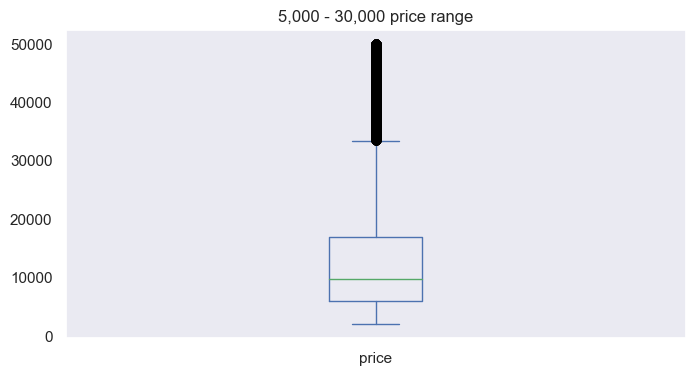

In [25]:
#filter data for price between 5k and 30k
df2 = df.loc[(df.price >= 2_000) & (df.price <= 50_000)]
sns.set()
fig,ax1=plt.subplots(figsize=(8,4))
df2.price.plot(kind='box')
ax1.set_title('5,000 - 30,000 price range')
plt.grid(False)

In [26]:
df2.price.max()

50000

In [27]:
df2.price.min()

2000

In [28]:
df2.shape

(73184, 12)

In [29]:
df2['odometer'].max()

10000000.0

In [30]:
df2.odometer.min()

0.0

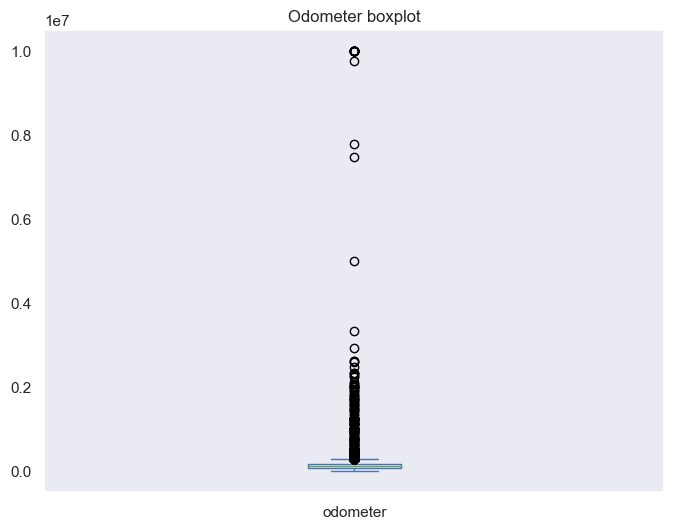

In [31]:
# use boxplots to find outliers in the odometer column
fig,ax = plt.subplots(figsize=(8,6))
df2.odometer.plot(kind='box')
plt.title('Odometer boxplot')
plt.grid(False)

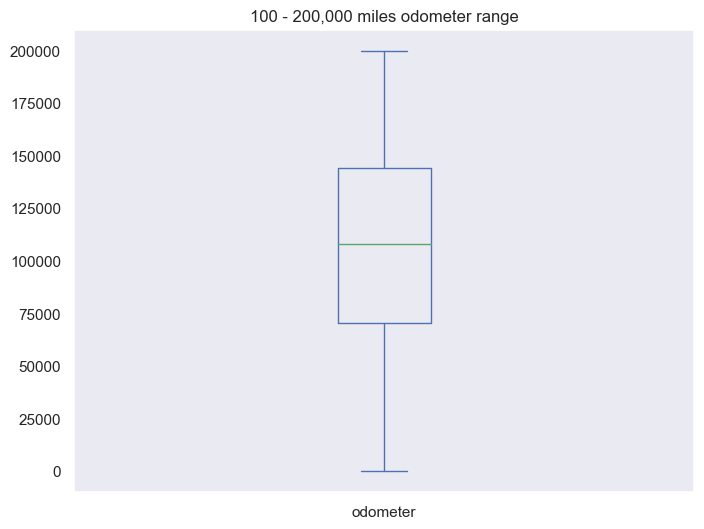

In [32]:
#filter data for odometer between 100 miles and 100,000 km
df2 = df2.loc[(df.odometer >= 100) & (df2.odometer <= 200_000)]
fig,(ax) = plt.subplots(figsize=(8,6))
df2.odometer.plot(kind='box')
ax.set_title('100 - 200,000 miles odometer range')
plt.grid(None)

In [33]:
df2.shape

(66311, 12)

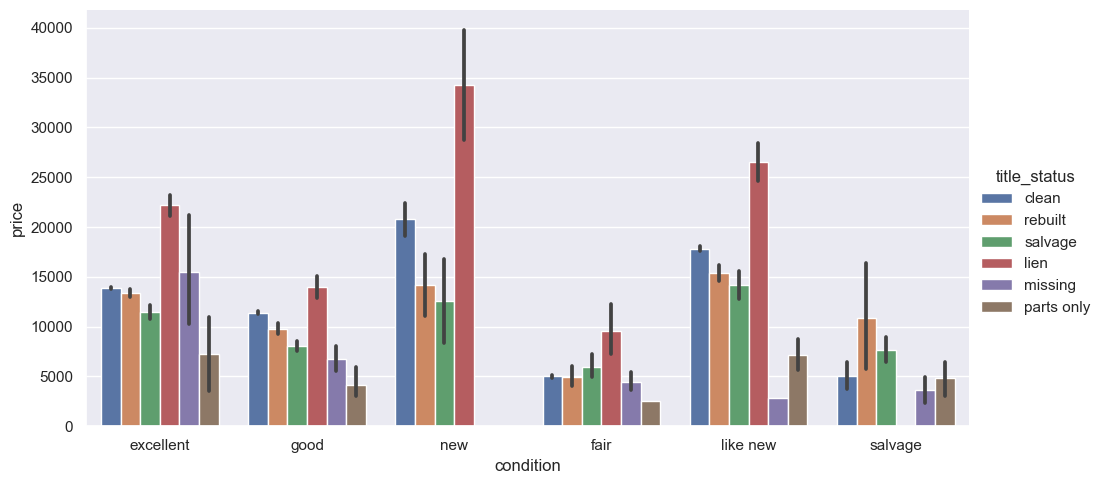

In [34]:
sns.catplot(x='condition', y ='price', hue='title_status', data=df2,
             kind="bar", aspect=2, height=5)

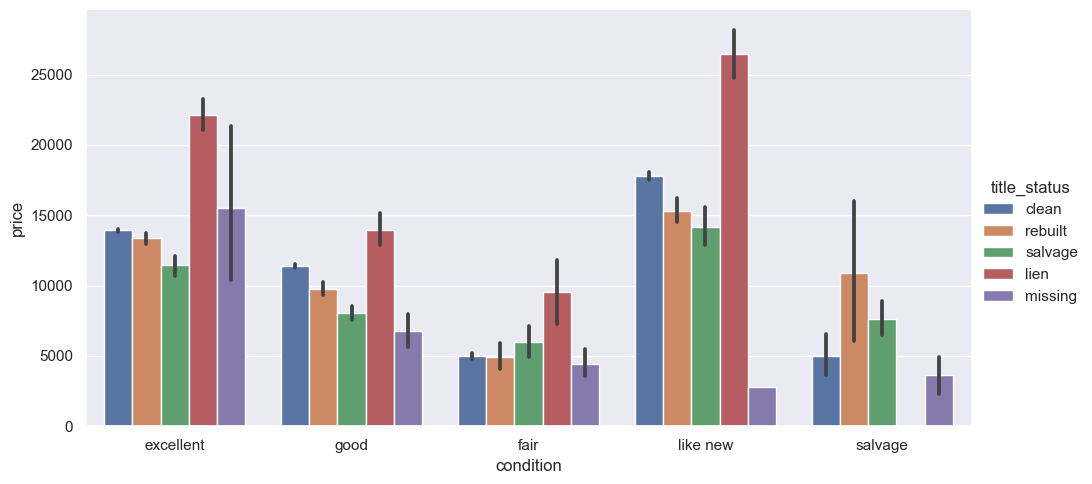

In [35]:
# Remove cars that are 'new' and have 'parts only'
df2= df2[df2.condition != 'new']

df2 = df2[df2.title_status != 'parts only']

sns.catplot(x='condition', y ='price', hue='title_status', data=df2, 
            kind="bar", aspect=2, height=5)


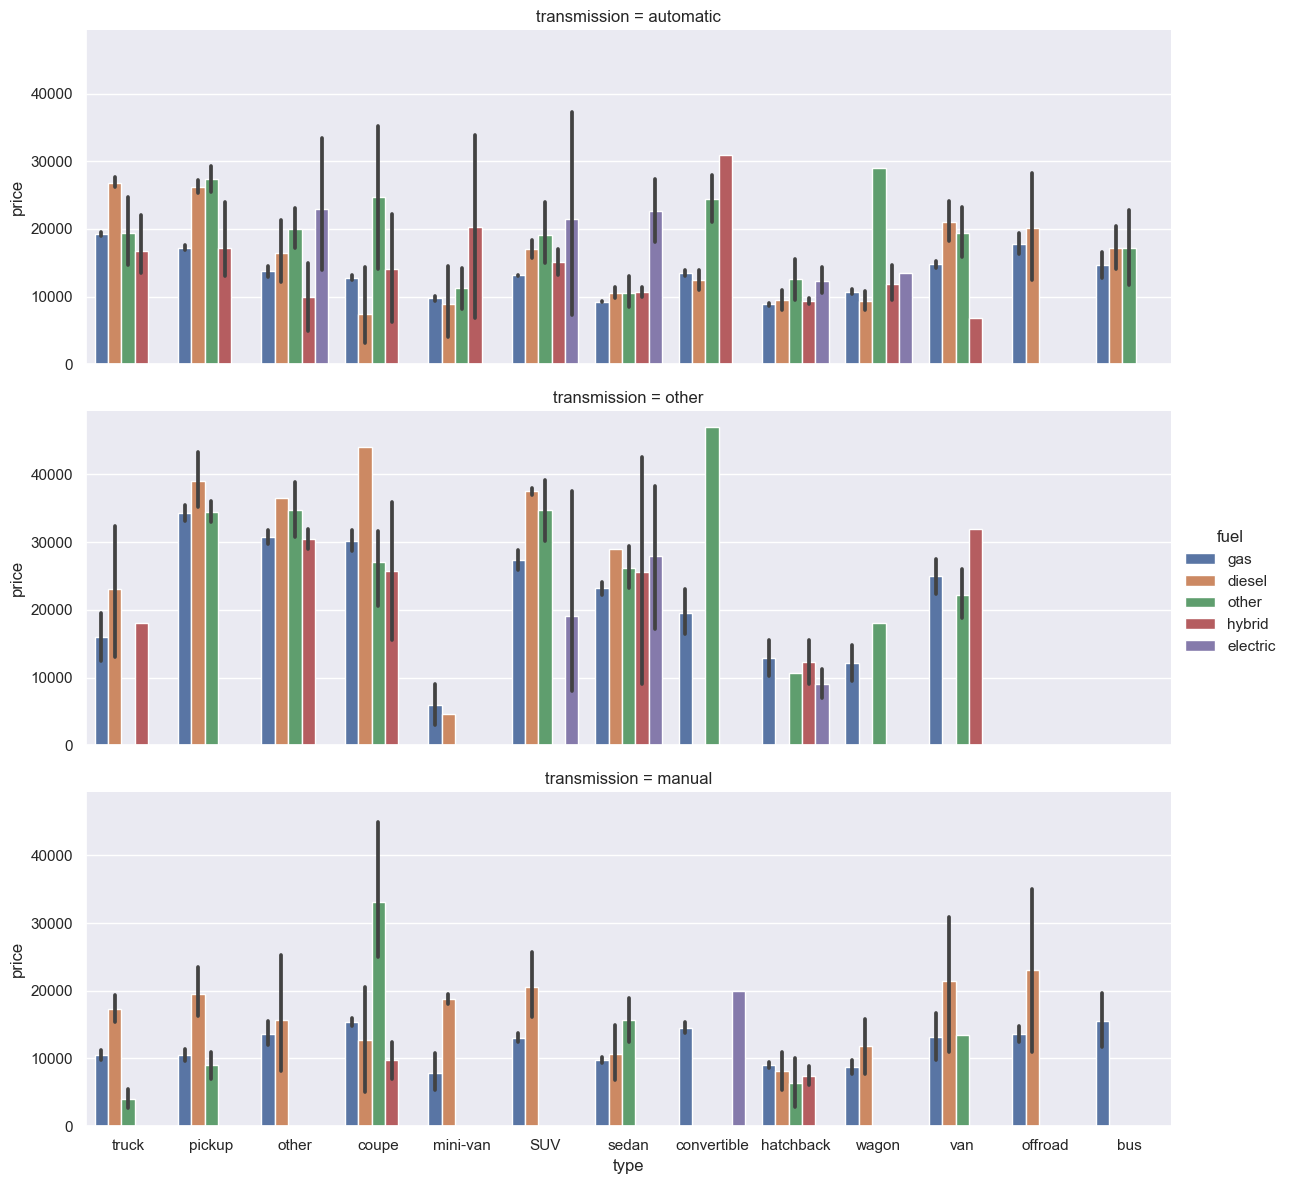

In [36]:
# Categorical plot between fuel and price for each type of trasmission 
sns.catplot(x='type', y ='price', hue='fuel', col='transmission', data=df2, kind="bar", 
            aspect=3, height=4, col_wrap=1)

<AxesSubplot:xlabel='title_status', ylabel='count'>

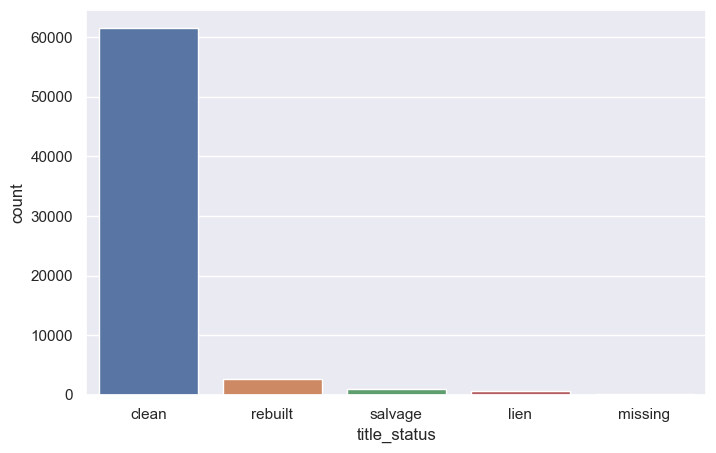

In [37]:
# plot showing the distribution of the title status
plt.figure(figsize=(8,5))
sns.countplot(data=df2, x='title_status')

<AxesSubplot:xlabel='condition', ylabel='count'>

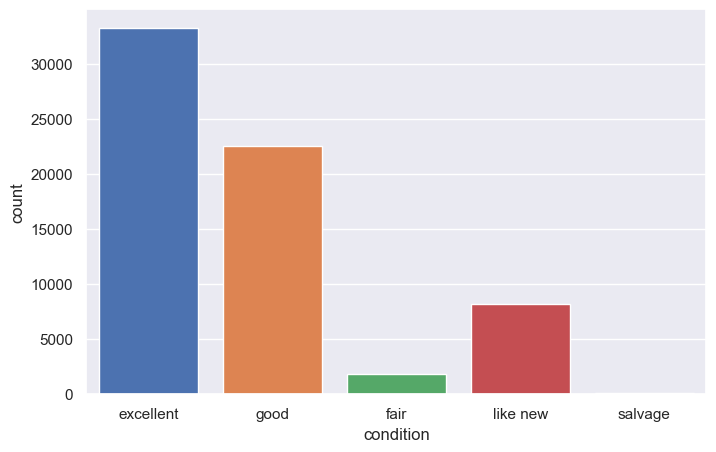

In [38]:
# plot showing the distribution of the various conditions of the vehicles
plt.figure(figsize=(8,5))
sns.countplot(data=df2, x='condition', saturation = 5)

<AxesSubplot:xlabel='cylinders', ylabel='count'>

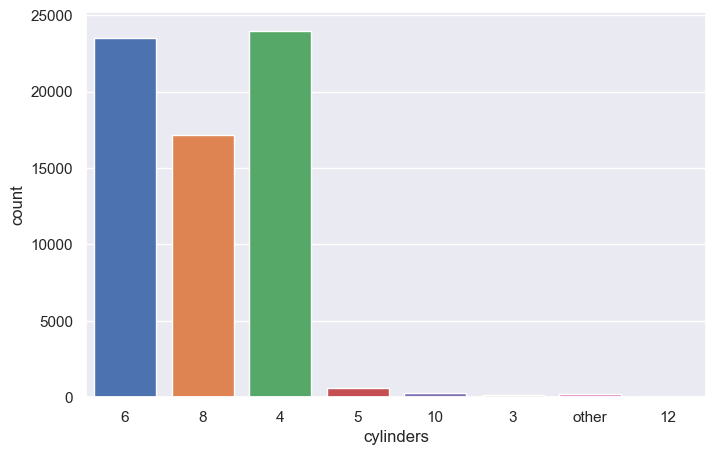

In [39]:
# plot showing the distribution of the different types of cylinders of the vehicles
plt.figure(figsize=(8,5))
sns.countplot(data = df2, x='cylinders', saturation = 8)

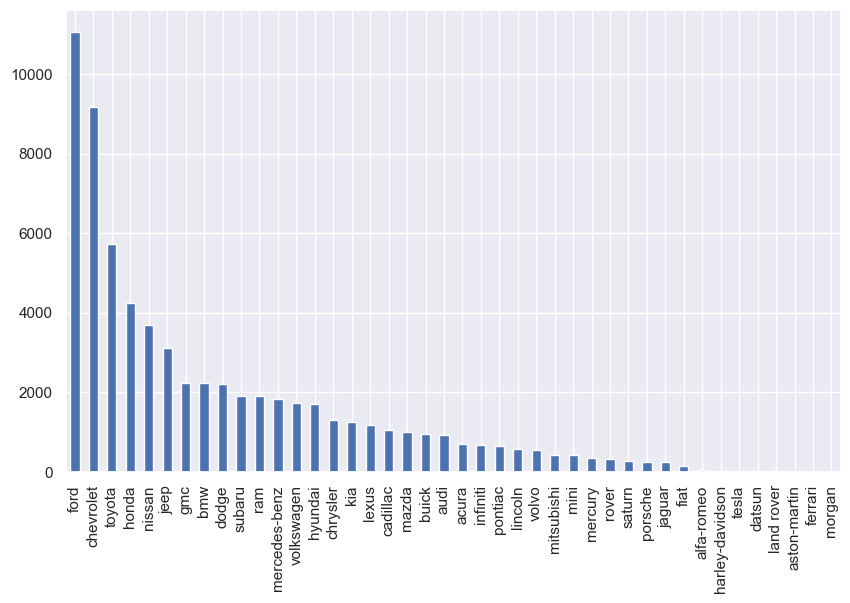

In [40]:
# plot showing the distribution of the different manufacturers of the vehicles
plt.figure(figsize = (10,6))
df2['manufacturer'].value_counts().plot(kind='bar')
plt.show()

<AxesSubplot:xlabel='paint_color', ylabel='count'>

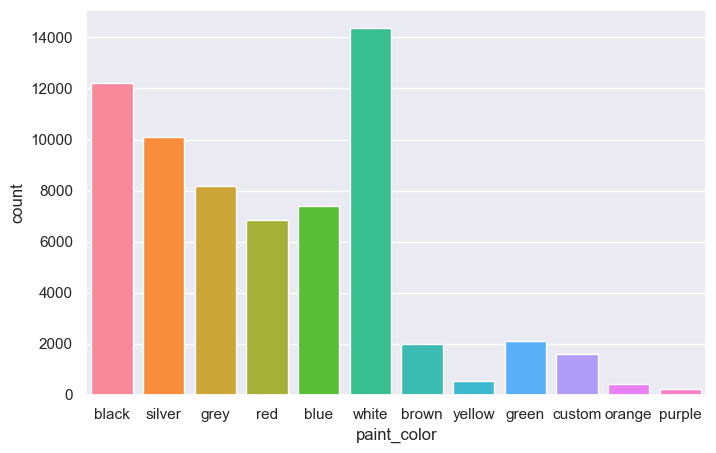

In [41]:
# plot showing the distribution of the different colors of the vehicles
plt.figure(figsize=(8,5))
sns.countplot(data=df2, x='paint_color', saturation = 8)

<AxesSubplot:xlabel='drive', ylabel='count'>

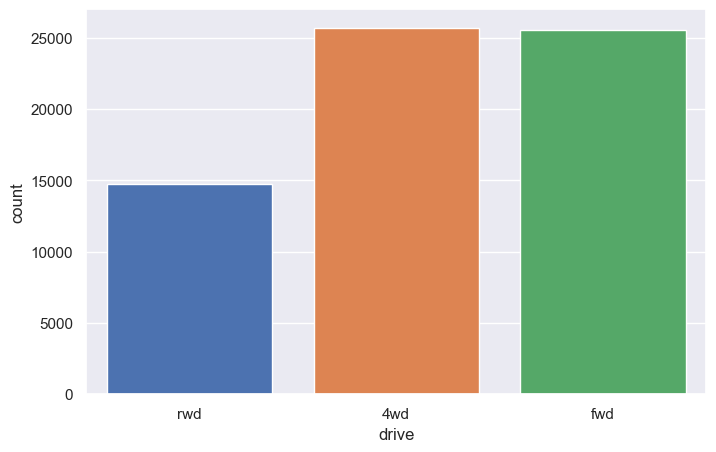

In [42]:
# plot showing the distribution of the different wheel drives of the vehicles
plt.figure(figsize=(8,5))
sns.countplot(data=df2, x='drive', saturation = 5)

<AxesSubplot:xlabel='type', ylabel='count'>

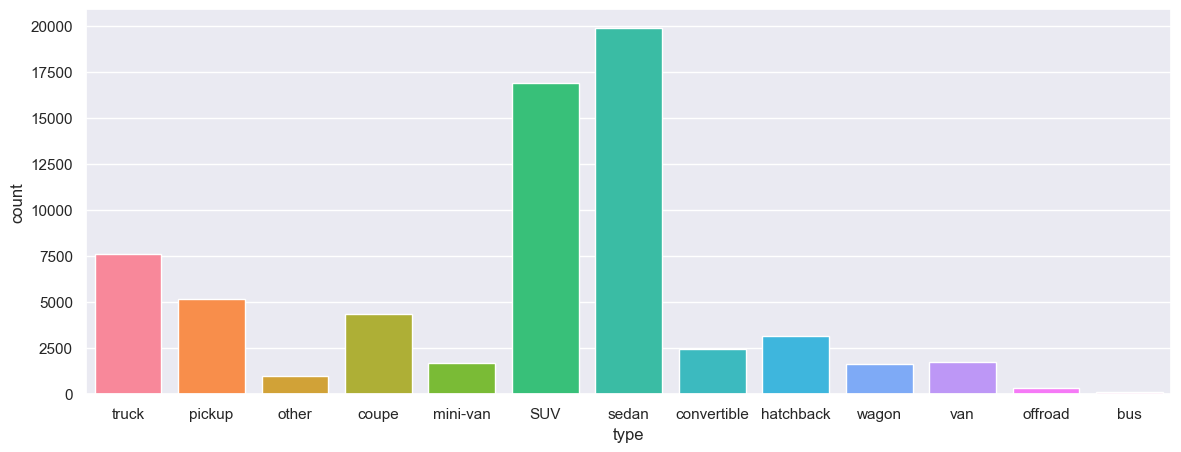

In [43]:
# plot showing the distribution of the different types of vehicles
plt.figure(figsize=(14,5))
sns.countplot(data=df2, x='type', saturation = 8)

<AxesSubplot:xlabel='fuel', ylabel='count'>

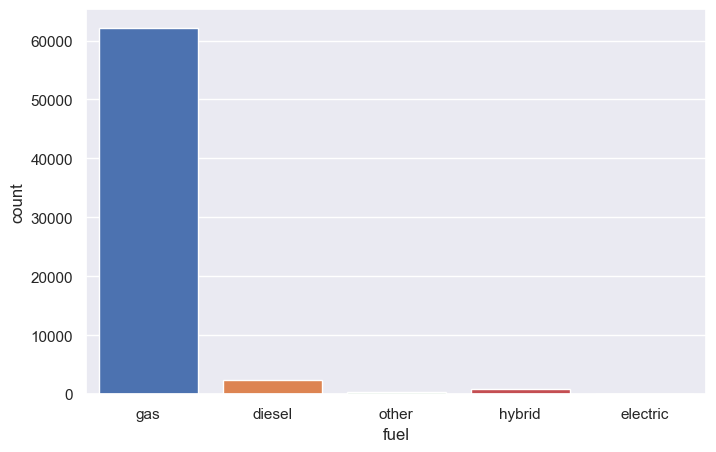

In [44]:
# plot showing the distribution of the different types of fuel
plt.figure(figsize=(8,5))
sns.countplot(data=df2, x='fuel', saturation = 8)

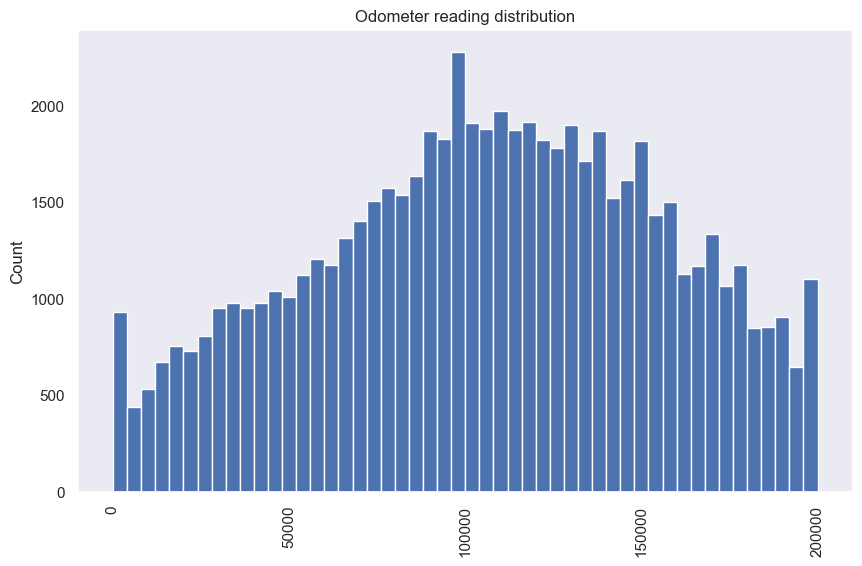

In [45]:
#check the odometer range 
fig,ax=plt.subplots(figsize=(10,6))
df2.odometer.hist(bins=50)
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(50000))
plt.title('Odometer reading distribution')
plt.grid(None)

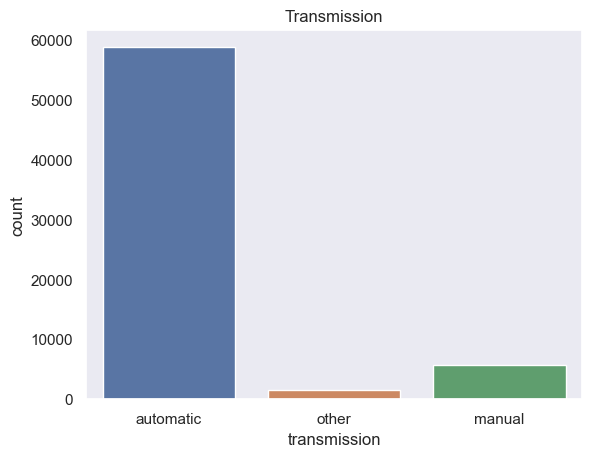

In [46]:
# check the distriution of vehicle transmissions 
sns.countplot(x='transmission',data=df2)
plt.title('Transmission')
plt.grid([])

In [47]:
# convert the year column from 'float64' to year type as 'int64'
df2['year'] = pd.to_datetime(df2['year'], errors='ignore', format='%y')

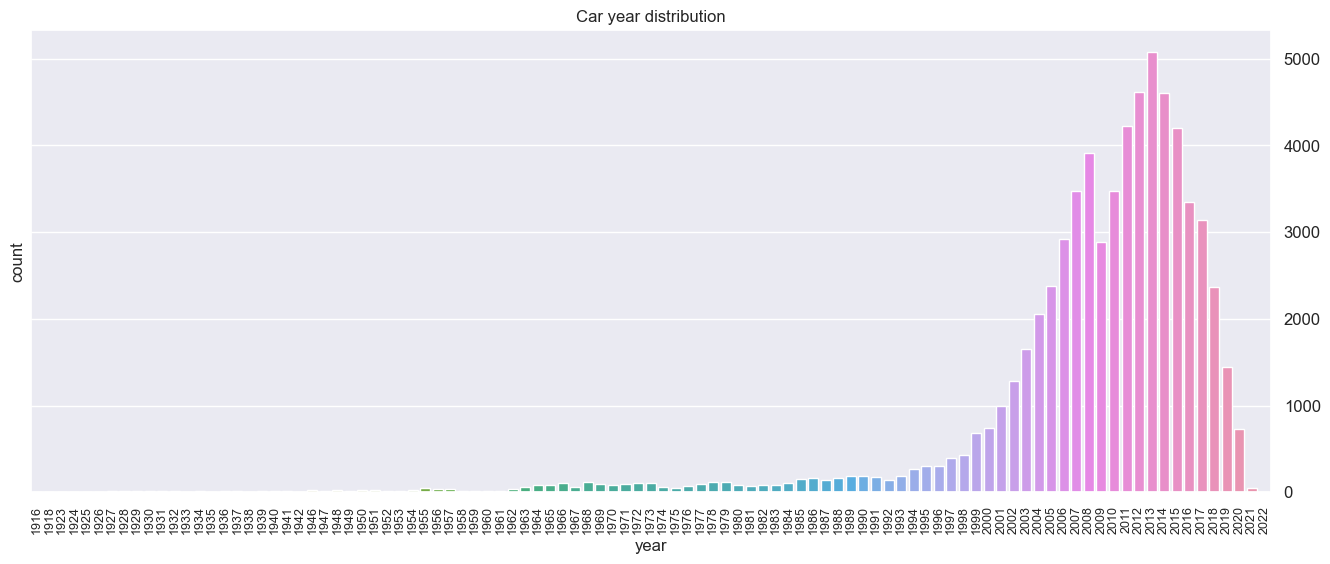

In [48]:
# plot showing the car year distribution
plt.figure(figsize=(16,6))
sns.countplot(x = 'year',data = df2)
plt.title('Car year distribution')
plt.tick_params(labelsize=12)
plt.xticks(fontsize=9,rotation=90)
plt.tick_params(axis='y', labelleft=False, labelright=True)
plt.show()

Distinguish older cars from newer ones. Create two new columns: age of cars by year, and average mileage of car per year

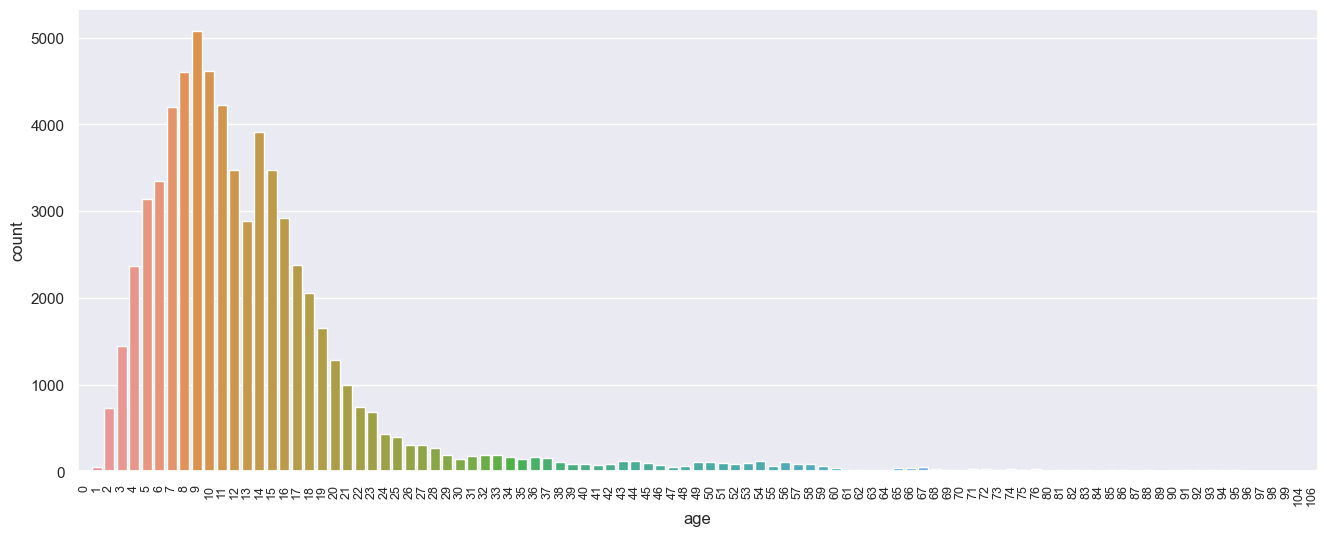

In [49]:
# create Age column
df2['age'] = 2021 - (df2['year'] - 1)

# plot Age distribution
plt.figure(figsize = (16,6))
sns.set()
sns.countplot(x ='age', data = df2)
plt.xticks(fontsize = 9, rotation = 90)
plt.show()

In [50]:
#take out the 0-1 year old cars
df2 = df2.loc[~(df2.age < 2)]

In [51]:
# create average mileage per year column
df2['avg_mileage'] = df2['odometer'] / df2['age']
df2.head()

/var/folders/m5/nhgvcry12b50frmgfg415ztc0000gn/T/ipykernel_6625/3810617583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['avg_mileage'] = df2['odometer'] / df2['age']


,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,age,avg_mileage
31,15000,2013,ford,excellent,6,gas,128000.0,clean,automatic,rwd,truck,black,9,14222.222222
32,27990,2012,gmc,good,8,gas,68696.0,clean,other,4wd,pickup,black,10,6869.600000
33,34590,2016,chevrolet,good,6,gas,29499.0,clean,other,4wd,pickup,silver,6,4916.500000
34,35000,2019,toyota,excellent,6,gas,43000.0,clean,automatic,4wd,truck,grey,3,14333.333333
35,29990,2016,chevrolet,good,6,gas,17302.0,clean,other,4wd,pickup,red,6,2883.666667


In [52]:
df2.shape

(65961, 14)

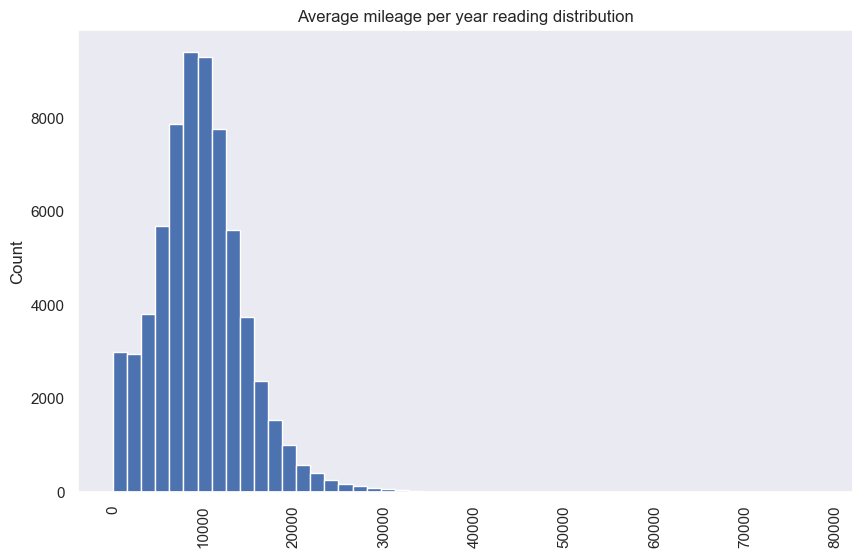

In [53]:
# check the average mileage range 
fig,ax = plt.subplots(figsize = (10,6))
df2.avg_mileage.hist(bins = 50)
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.title('Average mileage per year reading distribution')
plt.grid(None)

In [54]:
# drop year column
df2.drop(columns=['year', 'title_status'], inplace=True)
df2.head()

/Users/tolu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,price,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,age,avg_mileage
31,15000,ford,excellent,6,gas,128000.0,automatic,rwd,truck,black,9,14222.222222
32,27990,gmc,good,8,gas,68696.0,other,4wd,pickup,black,10,6869.600000
33,34590,chevrolet,good,6,gas,29499.0,other,4wd,pickup,silver,6,4916.500000
34,35000,toyota,excellent,6,gas,43000.0,automatic,4wd,truck,grey,3,14333.333333
35,29990,chevrolet,good,6,gas,17302.0,other,4wd,pickup,red,6,2883.666667


In [55]:
df2.shape

(65961, 12)

In [56]:
# reset index
df2.reset_index(drop=True, inplace=True)

In [57]:
# summary statistics of numnerical variables
df2.describe()

,price,odometer,age,avg_mileage
count,65961.000000,65961.000000,65961.000000,65961.000000
mean,13257.546535,106437.997362,13.774988,9676.447804
std,9749.609667,49423.146312,10.591325,5029.017300
min,2000.000000,100.000000,2.000000,1.020408
25%,6000.000000,71000.000000,8.000000,6473.684211
50%,9995.000000,108062.000000,11.000000,9400.000000
75%,17333.000000,144500.000000,16.000000,12400.000000
max,50000.000000,200000.000000,106.000000,78000.000000


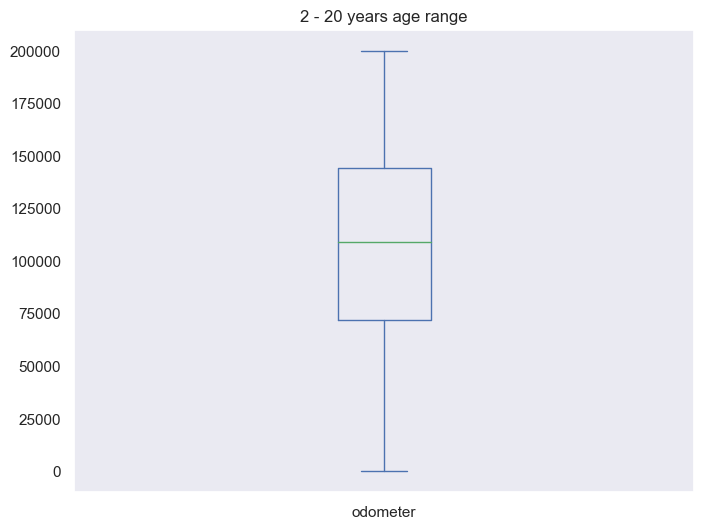

In [58]:
#filter data for car age between 2 and 20 years
df2 = df2.loc[(df2.age >= 2) & (df2.age <= 20)]
fig,(ax) = plt.subplots(figsize=(8,6))
df2.odometer.plot(kind='box')
ax.set_title('2 - 20 years age range')
plt.grid(None)

Text(0.5, -0.23, 'Fig: Correlation map')

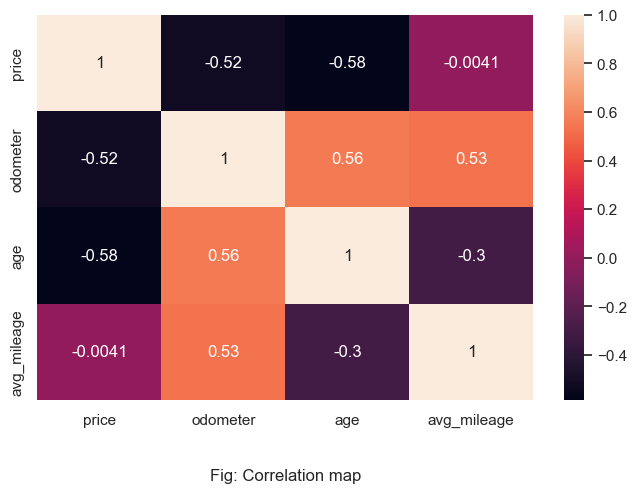

In [59]:
plt.figure(figsize = (8, 5))
sns.heatmap(df2.corr(),annot=True)
plt.title('Fig: Correlation map', y=-0.23)

In [60]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57790 entries, 0 to 65957
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         57790 non-null  int64  
 1   manufacturer  57790 non-null  object 
 2   condition     57790 non-null  object 
 3   cylinders     57790 non-null  object 
 4   fuel          57790 non-null  object 
 5   odometer      57790 non-null  float64
 6   transmission  57790 non-null  object 
 7   drive         57790 non-null  object 
 8   type          57790 non-null  object 
 9   paint_color   57790 non-null  object 
 10  age           57790 non-null  int64  
 11  avg_mileage   57790 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 5.7+ MB


In [61]:
# drop rows that contain string values in  the 'cylinder' column
df2 = df2.drop(df2[df2['cylinders'] == 'other'].index)

In [62]:
# convert the other values in the 'cylinder' column to float
df2['cylinders'] = df2['cylinders'].astype(float)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57618 entries, 0 to 65957
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         57618 non-null  int64  
 1   manufacturer  57618 non-null  object 
 2   condition     57618 non-null  object 
 3   cylinders     57618 non-null  float64
 4   fuel          57618 non-null  object 
 5   odometer      57618 non-null  float64
 6   transmission  57618 non-null  object 
 7   drive         57618 non-null  object 
 8   type          57618 non-null  object 
 9   paint_color   57618 non-null  object 
 10  age           57618 non-null  int64  
 11  avg_mileage   57618 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 5.7+ MB


## Modeling

In [63]:
# Label encode the "condition" column
le = LabelEncoder()
data = df2.copy()
data["condition_encoded"] = le.fit_transform(data["condition"])

# One-hot encode the other categorical variables
data = pd.get_dummies(data, columns=["manufacturer", "fuel", "transmission", 
                                 "drive", "type", "paint_color"])

# Drop the original categorical columns
data.drop(["condition"], axis=1, inplace=True)

# Display the resulting DataFrame
data.head()

,price,cylinders,odometer,age,avg_mileage,condition_encoded,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
0,15000,6.0,128000.0,9,14222.222222,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,27990,8.0,68696.0,10,6869.600000,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34590,6.0,29499.0,6,4916.500000,2,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,35000,6.0,43000.0,3,14333.333333,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,29990,6.0,17302.0,6,2883.666667,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [64]:
data.shape

(57618, 80)

## Linear Regression

In [65]:
# split the data to training and test set
train, test = train_test_split(data, test_size = 0.2, random_state = 0) 
print('Size of the train dataset is ', train.shape)
print('Size of the test dataset is ', test.shape)

Size of the train dataset is  (46094, 80)
Size of the test dataset is  (11524, 80)


In [66]:
# training predictor variables
x_train = train.iloc[:, 1:]

In [67]:
x_train.head()

,cylinders,odometer,age,avg_mileage,condition_encoded,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
37145,6.0,29000.0,5,5800.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5125,6.0,198000.0,18,11000.0,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1405,8.0,99500.0,10,9950.0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5175,4.0,79746.0,10,7974.6,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
24881,8.0,153000.0,8,19125.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [68]:
x_train.shape

(46094, 79)

In [69]:
# training outcome variable
y_train = train['price']

In [70]:
# test predictor variables
x_test = test.iloc[:, 1:]
x_test.head()

,cylinders,odometer,age,avg_mileage,condition_encoded,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
45021,6.0,60082.0,12,5006.833333,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
55965,6.0,59448.0,18,3302.666667,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
20288,4.0,156000.0,2,78000.000000,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36646,6.0,116885.0,11,10625.909091,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
13709,4.0,32432.0,6,5405.333333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [71]:
x_test.shape

(11524, 79)

In [72]:
# test outcome variable
y_test = test['price']

In [73]:
#Fit linear regression to training data
linear_regression = LinearRegression()
lr_model = linear_regression.fit(x_train, y_train)

In [74]:
# Check the significance of parameters
import statsmodels.api as sm
lr = sm.OLS(y_train, x_train)
lr = lr.fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     1800.
Date:                Fri, 28 Apr 2023   Prob (F-statistic):               0.00
Time:                        13:33:39   Log-Likelihood:            -4.5805e+05
No. Observations:               46094   AIC:                         9.163e+05
Df Residuals:                   46020   BIC:                         9.169e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
cylinders       

In [75]:
#Predict y based on test dataset
y_pred = lr_model.predict(x_test) 

In [76]:
# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)

In [77]:
# Print the R-squared score
print('R2 score: {:.2f}'.format(r2))

R2 score: 0.74


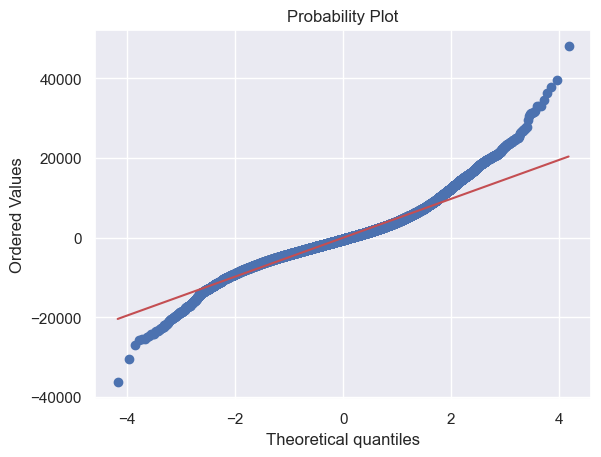

In [78]:
# QQ-plot
stats.probplot(y_train - linear_regression.predict(x_train), dist="norm", plot=plt)
plt.show()

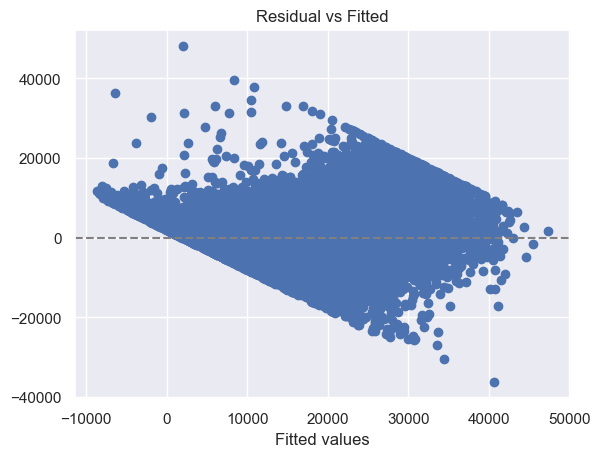

In [79]:
# Residual vs Fitted plot
residuals = y_train - linear_regression.predict(x_train)
plt.scatter(linear_regression.predict(x_train), residuals)
plt.xlabel('Fitted values')
plt.title('Residual vs Fitted')
plt.axhline(y = 0, color = 'grey', ls = '--')
plt.show()

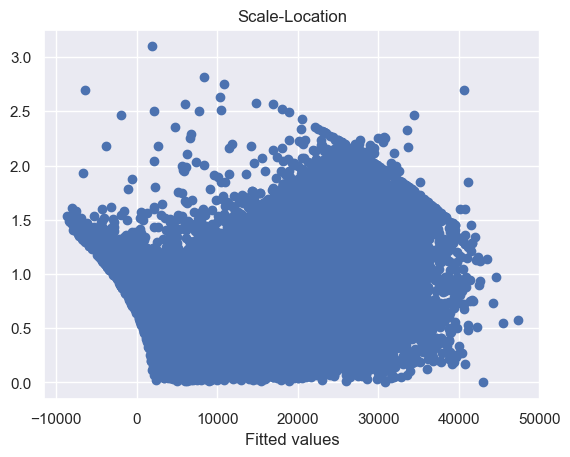

In [80]:
# Scale-Location plot
standardized_residuals = (residuals - residuals.mean()) / residuals.std()
plt.scatter(linear_regression.predict(x_train), np.sqrt(abs(standardized_residuals)))
plt.xlabel('Fitted values')
plt.title('Scale-Location')
plt.show()

In [81]:
#Create a pandas dataframe with two columns, one is the real value from our testing dataset, 
#and the other on is the predicted values based on the regression model
compare = pd.DataFrame({'Real Value': y_test, 'Predict Value': y_pred})

#y_test has its own row index, thus we need to reset the index and drop the 'index' column
compare.reset_index(inplace = True)
compare = compare.drop(['index'], axis = 1)
compare.head()

,Real Value,Predict Value
0,9995,10979.314164
1,13995,12303.191079
2,4900,18315.408073
3,14950,23926.164117
4,10800,17778.716153


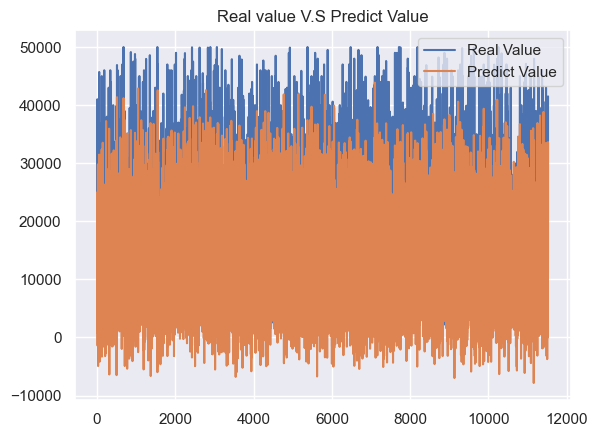

In [82]:
compare.plot()
plt.title('Real value V.S Predict Value')
plt.show()

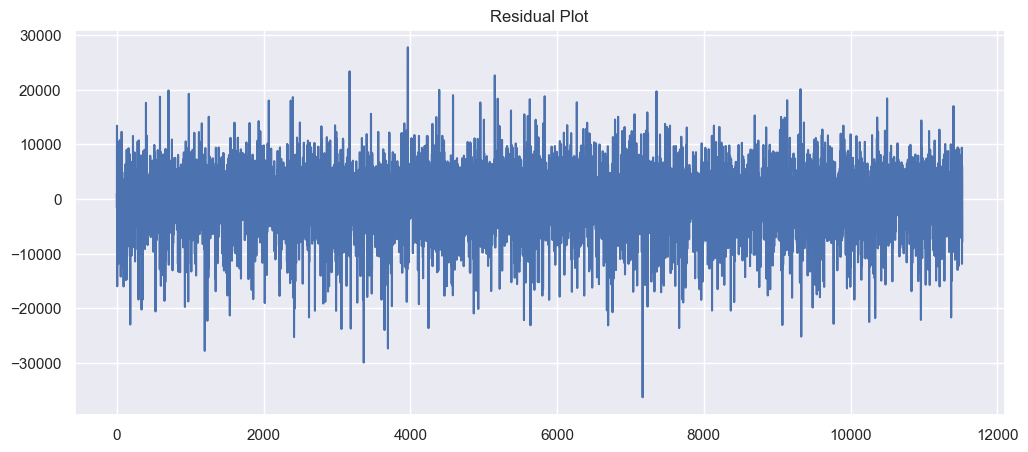

In [83]:
#Plot residuals in testing dataset
plt.figure(figsize = (12, 5))
plt.plot(compare['Predict Value'] - compare['Real Value'])
plt.title('Residual Plot')
plt.show()

In [84]:
# Define a function for output statistics
def d_metrics(pred_model, x_train, x_test, y_train, y_test):
    """ Function takes in training and testing sets, prediction model, 
    and ouputs the below metrics:
    1. R² or Coefficient of Determination.
    2. Adjusted R²
    3. Mean Squared Error(MSE)
    4. Root-Mean-Squared-Error(RMSE).
    5. Mean-Absolute-Error(MAE).
    """
    # Get predicted values on x_test
    y_pred = pred_model.predict(x_test)

    #1 & 2 Coefficient of Determination (R² & Adjusted R²)
    print("\n\t--- Coefficient of Determination (R² & Adjusted R²) ---")
    r2 = metrics.r2_score(y_pred=y_pred, y_true=y_test)
    adj_r2 = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)

    print(f"R²\t\t: {round(r2, 3)}")
    print(f"Adjusted R²\t: {round(adj_r2, 3)}")
    

    #MSE and RMSE
    print("\n\t--- Mean Squared Error (MSE & RMSE) ---")
   
    mse = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=True)
    rmse = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)

    print(f"MSE\t: {round(mse, 2)}")
    print(f"RMSE\t: {round(rmse, 2)}")


    #MAE
    print("\n\t--- Mean Absolute Error (MAE) ---")
    mae = metrics.mean_absolute_error(y_pred=y_pred, y_true=y_test)
    print(f"MAE\t: {round(mae, 2)}")

    return (round(r2,3), round(adj_r2,3))

In [85]:
# Define a dataframe to summarize accuracies for later
algo_list = ['Linear Regression','Decision Trees', 'Bagging', 'Random Forest', 
             'Adaptive Boosting', 'Gradient Boosting', 'XGBoost']
metrics_cols = ['R2 Score', 'Adjusted R2 Score']

metrics_df = pd.DataFrame(columns=metrics_cols, index=algo_list)

metrics_df.index.name='Algorithm'

In [86]:
print("\t------- Linear Regression -------")
lr_metrics = d_metrics(linear_regression, x_train, x_test, y_train, y_test)
metrics_df.loc['Linear Regression'] = lr_metrics

	------- Linear Regression -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.741
Adjusted R²	: 0.74

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 24826556.67
RMSE	: 4982.63

	--- Mean Absolute Error (MAE) ---
MAE	: 3619.9


## Decision Tree Regressor

In [87]:
# Decision Tree 
# A graphical representation of possible solutions to a decision based on certain conditions
dtree_reg = DecisionTreeRegressor()
dtree_reg.fit(x_train, y_train)

print("\t------- Decision Tree Regressor -------")
dtree_metrics = d_metrics(dtree_reg, x_train, x_test, y_train, y_test)
metrics_df.loc['Decision Trees'] = dtree_metrics

	------- Decision Tree Regressor -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.695
Adjusted R²	: 0.694

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 29220818.73
RMSE	: 5405.63

	--- Mean Absolute Error (MAE) ---
MAE	: 3558.73


## Bagging Regressor

In [88]:
# Bagging Regression
# Meta-algorithm combining predictions from multiple-decision
#  trees through a majority voting mechanism

bag_reg = BaggingRegressor()
bag_reg.fit(x_train, y_train)

print("\t------- Bagging Regressor -------")
bag_metrics = d_metrics(bag_reg, x_train, x_test, y_train, y_test)

metrics_df.loc['Bagging'] = bag_metrics

	------- Bagging Regressor -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.822
Adjusted R²	: 0.822

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 17047530.14
RMSE	: 4128.87

	--- Mean Absolute Error (MAE) ---
MAE	: 2756.85


## Random Forest Regressor

In [89]:
# Random Forest Regressor
# Bagging-based algorithm where only a subset of features are selected at
# random to build a forest or collection of decision trees

rf_reg = RandomForestRegressor()
rf_reg.fit(x_train, y_train)

print("\t------- Random Forest Regressor -------")
rf_metrics = d_metrics(rf_reg, x_train, x_test, y_train, y_test)

metrics_df.loc['Random Forest'] = rf_metrics

	------- Random Forest Regressor -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.837
Adjusted R²	: 0.836

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 15657303.7
RMSE	: 3956.93

	--- Mean Absolute Error (MAE) ---
MAE	: 2627.13


## Adaptive Boosting Regressor

In [90]:
# Adaboost Regression
# Models are built sequentially by minimizing the errors from previous models while
# increasing (or boosting) influence of high-performing models
ab_reg = AdaBoostRegressor()
ab_reg.fit(x_train, y_train)


print("\t------- Adaboost Regression -------")
ab_metrics = d_metrics(ab_reg, x_train, x_test, y_train, y_test)

metrics_df.loc['Adaptive Boosting'] = ab_metrics

	------- Adaboost Regression -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.558
Adjusted R²	: 0.557

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 42327741.21
RMSE	: 6505.98

	--- Mean Absolute Error (MAE) ---
MAE	: 5293.49


## Gradient Boosting Regressor

In [91]:
# Gradient Boosting Regressor
# Gradient Boosting employs gradient descent algorithm to minimize errors in sequential models

gb_reg = GradientBoostingRegressor()
gb_reg.fit(x_train, y_train)


print("\t------- Gradient Boosting Regressor -------")
gb_metrics = d_metrics(gb_reg, x_train, x_test, y_train, y_test)

metrics_df.loc['Gradient Boosting'] = gb_metrics

	------- Gradient Boosting Regressor -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.808
Adjusted R²	: 0.808

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 18365695.12
RMSE	: 4285.52

	--- Mean Absolute Error (MAE) ---
MAE	: 2936.34


## XGBoost Regressor

In [92]:
# XGBoost
# Optimized Gradient Boosting algorithm through parallel processing, tree-pruning,
# handling missing values and regularization to avoid overfitting/bias

xgb_reg = xgb.XGBRegressor() 
xgb_reg.fit(x_train, y_train)

print("\t------- XGBoost Regression -------")
xgb_metrics = d_metrics(xgb_reg, x_train, x_test, y_train, y_test)

metrics_df.loc['XGBoost'] = xgb_metrics

	------- XGBoost Regression -------

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.849
Adjusted R²	: 0.849

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 14453272.38
RMSE	: 3801.75

	--- Mean Absolute Error (MAE) ---
MAE	: 2548.95


## Summary of Model Perfomances

In [93]:
# All metrics from the above algorithms
metrics_df

,R2 Score,Adjusted R2 Score
Algorithm,,
Linear Regression,0.741,0.74
Decision Trees,0.695,0.694
Bagging,0.822,0.822
Random Forest,0.837,0.836
Adaptive Boosting,0.558,0.557
Gradient Boosting,0.808,0.808
XGBoost,0.849,0.849
